X.npy: numeric feature dataset. Extract columns

In [ ]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv("reducedDatasets/botnet_sorted.csv")

# Select only numeric feature columns
feature_cols = [
    "duration",
    "packets_count",
    "total_payload_bytes",
    "bytes_rate",
    "syn_flag_counts"
]

# Convert to NumPy
X = df[feature_cols].values

# Save
np.save("X.npy", X)
print("Saved X.npy with shape:", X.shape)

y.npy: Construct label dataset (ex. [1, 1, -1])

In [ ]:
df = pd.read_csv("reducedDatasets/botnet_sorted.csv") 

y = []
bot_count = 0
max_bots = 100

# 1 = attack, -1 = benign
for label in df['label']:
    if label == 'Benign':
        y.append(-1)
    elif label == 'Bot':
        if bot_count < max_bots:
            y.append(1)
            bot_count += 1
        else:
            continue

np.save("y.npy", np.array(y))
print("Saved y.npy with", len(y), "labels.")


## COMPUTE BETTI CURVE VECTOR

In [ ]:
import numpy as np
import gudhi
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def compute_betti_curve(points, epsilons, max_dim=2):
    # Build Rips & compute persistence
    rips = gudhi.RipsComplex(points=points, max_edge_length=epsilons[-1])
    st   = rips.create_simplex_tree(max_dimension=max_dim)
    st.compute_persistence()

    betti = np.zeros((max_dim+1, len(epsilons)), dtype=int)
    intervals = st.persistence_intervals_in_dimension

    # Vectorized ε‐sweep via searchsorted
    for dim in range(max_dim+1):
        for birth, death in intervals(dim):
            i0 = np.searchsorted(epsilons, birth, side='left')
            i1 = np.searchsorted(epsilons, death, side='left')
            if i1 > i0:
                betti[dim, i0:i1] += 1
    return betti


# --- PARAMETERS ---
max_dim     = 2
n_neighbors = 20
max_edge    = 1
resolution  = 100
epsilons    = np.linspace(0, max_edge, resolution)

# --- LOAD DATA ---
X = np.load("X.npy")            # feature vectors
y = np.load("y.npy")            # labels: 1=attack, -1=benign

# --- PREPROCESS & NEIGHBORS ---
X_scaled = StandardScaler().fit_transform(X) # must normalize because data values vary
nbrs     = NearestNeighbors(n_neighbors=n_neighbors).fit(X_scaled)

# Identify all attack indices automatically
anomaly_idx = np.where(y == 1)[0]    # array of row‐indices where y==1

# Preallocate results: (n_attacks, dims+1, resolution)
all_betti = np.zeros((len(anomaly_idx), max_dim+1, resolution), dtype=int)

# --- LOOP OVER EACH ANOMALY ---
for k, idx in enumerate(anomaly_idx):
    _, nbr_inds = nbrs.kneighbors(X_scaled[idx:idx+1])
    cloud       = X_scaled[nbr_inds[0]]
    all_betti[k] = compute_betti_curve(cloud, epsilons, max_dim=max_dim)

[[20  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

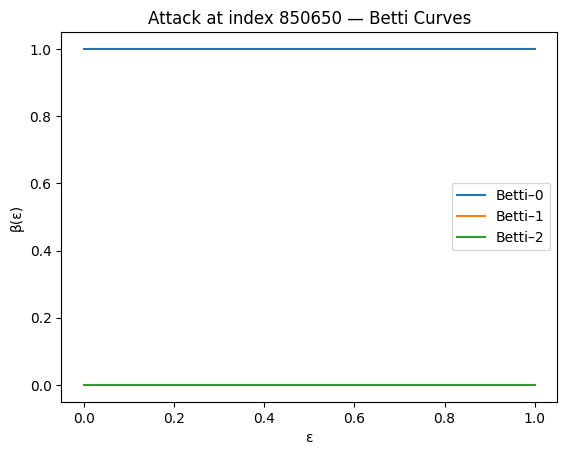

In [7]:
# --- PLOT ONE EXAMPLE ---
example = 4
plt.figure()
for dim in range(max_dim+1):
    plt.plot(epsilons, all_betti[example, dim], label=f"Betti–{dim}")
plt.xlabel("ε")
plt.ylabel("β(ε)")
plt.title(f"Attack at index {anomaly_idx[example]} — Betti Curves")
plt.legend()
plt.show()